# Tutorial: supervision with ordinal labels

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import networkx as nx
import pacmap
import elpigraph
import stream as st
import stream2 as st2
from sklearn.neighbors import NearestNeighbors

# Load data
We directly load preprocessed data subsampled ~10% of points with geosketch

Uncomment the cell below if you wish to replicate preprocessing yourself

In [2]:
adata = sc.read('../data/wot.h5ad')

In [3]:
## download data from https://broadinstitute.github.io/wot/tutorial/
#import wot
#
#PATH = '../../git/wot/notebooks/data/'
#
##---Path to input files
#FLE_COORDS_PATH ='data/fle_coords.txt'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
#CELL_DAYS_PATH = 'data/cell_days.txt'
#GENE_SETS_PATH = 'data/gene_sets.gmx'
#GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
#CELL_SETS_PATH = 'data/cell_sets.gmt'
#MAJOR_CELL_SETS_PATH = 'data/major_cell_sets.gmt'
#SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
#CELL_GROWTH_PATH = 'data/growth_gs_init.txt'
#
#coord_df = pd.read_csv(PATH+FLE_COORDS_PATH, index_col='id', sep='\t')
#days_df = pd.read_csv(PATH+CELL_DAYS_PATH, index_col='id', sep='\t')
#gene_set_df = pd.read_csv(PATH+GENE_SET_SCORES_PATH, index_col='id').rename(columns={'Trophoblast':'Trophoblast.identity'})
#cell_sets = wot.io.read_sets(PATH+CELL_SETS_PATH)
#serum_id = pd.read_csv(PATH+SERUM_CELL_IDS_PATH,header=None)
#adata = sc.read_h5ad(PATH+VAR_DS_PATH)
#
## subset labeled days
#adata.obs['label']=days_df
#adata=adata[~adata.obs['label'].isna()].copy()
#sc.pp.pca(adata)
#
## add annotations
#df=cell_sets.to_df()
#df['cell_sets'] = ''
#for c in df.columns[:-1]: 
#    df.loc[df[c]>0,'cell_sets']=c
#adata.obs=adata.obs.join(df)
#adata.obs.loc[adata.obs['cell_sets'].isna(),'cell_sets']='nan'
#adata.obs['cell_sets']=adata.obs['cell_sets'].astype(str)
#
#adata.obs['cell_sets_simple']=adata.obs['cell_sets'].copy()
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Trophoblast','SpongioTropho','ProgenitorTropho','SpiralArteryTrophoGiant'])] = 'Trophoblast'
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Neural','RadialGlia','Neuron','Astrocyte'])] = 'Neural'  
#adata.uns['cell_sets_simple_color'] = {
# 'Epithelial': '#EC8E26',
# 'IPS': '#c0c1c0',
# 'MET': '#9e50c7',
# 'Neural': '#47e026',
# 'OPC': '#7f7f7f',
# 'Stromal': '#3f4af4',
# 'Trophoblast': '#b5361a',
# 'nan': '#434342'}
#
#adata.obs['serum']='0'
#adata.obs['serum'][adata.obs.index.isin(serum_id[0].values)]='1'
#
#from geosketch import gs
#sketch_index = gs(adata.obsm['X_pca'], N=25000, replace=False,seed=0)
#s_adata = adata[sketch_index]
#s_adata.write('../data/wot.h5ad')

# Supervised dimension reduction
We can correct outlier ordinal labels by voting

In [4]:
k = 30

knn_label_vote = adata.obs['label'].copy()
dis, idx = NearestNeighbors(n_neighbors=k,n_jobs=8).fit(adata.obsm['X_pca']).kneighbors()

for i, x in enumerate(np.array(adata.obs['label'])[idx]):
    unique, count = np.unique(x, return_counts=1)
    argmax = np.argmax(count)
    if count[argmax] > k/2: 
        knn_label_vote[i] = unique[argmax]
        
adata.obs['knn_label_vote'] = knn_label_vote

We perform unsupervised dimensionality reduction as baseline

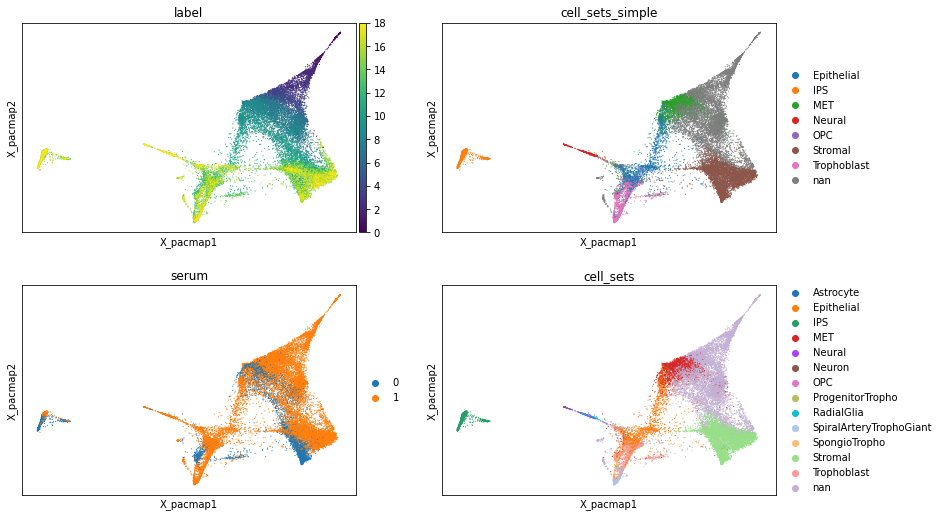

In [5]:
adata.obsm['X_pacmap'] = pacmap.PaCMAP(n_neighbors=k, distance='angular',random_state=0, FP_ratio=.4).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap',color=['label','cell_sets_simple','serum','cell_sets'],ncols=2)

In this dataset cells are already quite well ordered by time. Still there are discrepancies where earlier cells are sampled near the tip of the distribution and after cells from later days. 

In such case there is a decision to be made which notion of time we care more about respecting: pseudotime vs wall time. If we want to perfectly follow wall time, we can perform supervised dimensionality reduction using ordinal labels to create more separation between time points.

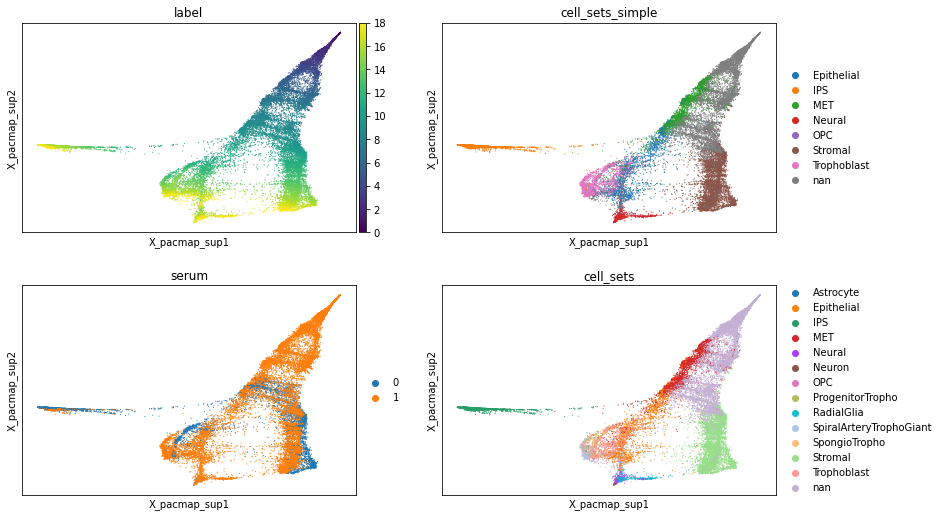

In [6]:
knn_dists,knn_idx = st2.tl.ordinal_knn(adata,obsm='X_pca',ordinal_label='label', method='force',
                                          n_neighbors = k, n_natural = 2, metric = 'cosine')


scaled_dist = np.ones_like(knn_idx,dtype='float32')
pair_neighbors = pacmap.sample_neighbors_pair(adata.obsm['X_pca'], scaled_dist, knn_idx, k)
adata.obsm['X_pacmap_sup'] = pacmap.PaCMAP(n_neighbors=k,random_state=0,FP_ratio=.4,
                                           pair_neighbors=pair_neighbors).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap_sup',color=['label','cell_sets_simple','serum','cell_sets'],ncols=2)

# Trajectory inference
Let us seed the graph with a minimum spanning tree. 
We can see that 10 clusters is not enough

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


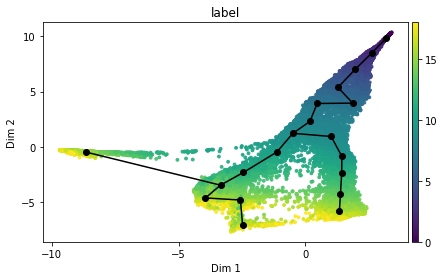

In [7]:
adata.obsm['X_dr']=adata.obsm['X_pacmap_sup']
st2.tl.seed_graph(adata,n_clusters=20,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

A simple solution is to increase the number of clusters

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


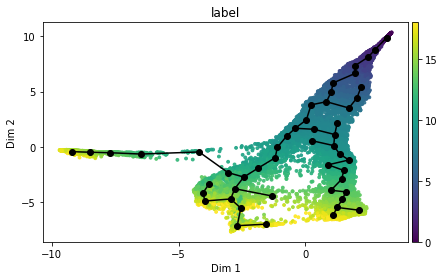

In [8]:
st2.tl.seed_graph(adata,n_clusters=50,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

We can see that the seed graph is still not ideal, e.g. for IPS cells because the start of the branch
is very sparse.

We can improve this by computing density and assigning higher weights to points in sparse regions of data

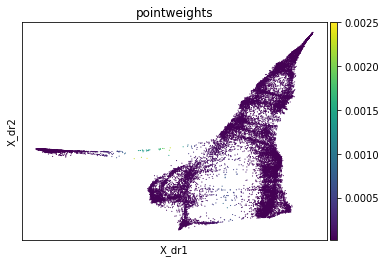

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


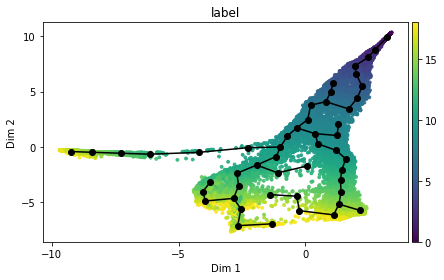

In [9]:
st2.tl.get_weights(adata,bandwidth=.5,method='fft')
sc.pl.embedding(adata,basis='X_dr',color='pointweights')

st2.tl.seed_graph(adata,n_clusters=50,use_weights=True)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

We now refine the guess by computing an unsupervised principal graph

Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  90  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

7||51	0.5845	51	50	35	7	0	0	0.2413	0.1981	0.9929	0.9942	0.3223	0.0209	1.0646	54.2967	0
6||52	0.5565	52	51	38	6	0	0	0.2393	0.2003	0.993	0.9941	0.3046	0.0126	0.6562	34.1227	0
5||53	0.5748	53	52	41	5	0	0	0.2501	0.2122	0.9926	0.9938	0.2948	0.03	1.5889	84.2119	0
5||54	0.5485	54	53	42	5	0	0	0.2411	0.2068	0.9929	0.9939	0.2818	0.0256	1.3806	74.5519	0
5||55	0.5387	55	54	43	5	0	0	0.2448	0.2126	0.9928	0.9937	0.2679	0.026	1.4299	78.645	0
4||56	0.5281	56	55	46	4	0	0	0.246	0.2147	0.9928	0.9937	0.2572	0.0249	1.3928	77.9941	0
4||57	0.5168	57	56	47	4	0	0	0.2442	0.2143	0.9928	0.9937	0.2507	0.0219	1.2484	71.1609	0
3||58	0.5154	58	57	50	3	0	0	0.2402	0.2102	0.9929	0.9938	0.2513	0.0239	1.3834	80.2387	0
3||59	0.5107	59	58	51	3	0	0	0.2426	0.214	0.9929	0.9937	0.244	0.0242	1.4257	84.1157	0
3||60	0.5007	60	59	52	

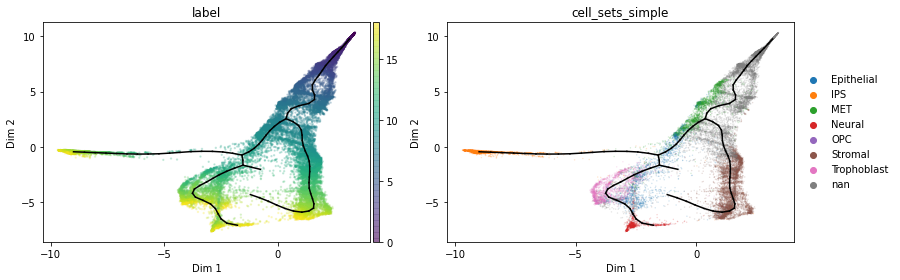

In [10]:
st2.tl.learn_graph(adata,n_nodes=90,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
                   use_weights=True, GPU=True, store_evolution=True,
                   max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},
                   verbose=1,)
st2.pl.graph(adata,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

Since we used `store_evolution=True` we have access to graphs <br> for any number of nodes between
n_clusters of the seed graph and n_nodes

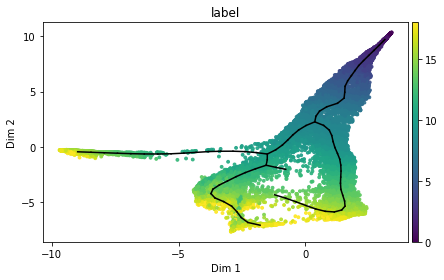

In [11]:
st2.tl.use_graph_with_n_nodes(adata,n_nodes=80)
st2.pl.graph(adata,key='epg',color=['label'])

While the structure is better than the seed graph, some branches do not perfectly follow our ordinal labels.
<br>
We can compute a supervised principal graph to try getting better results
<br>
<br>
Ordinal labels should be smoothed into a continuous variable before learning the supervised graph <br>
(here they are already quite smooth so we discretize them into 3 bins as an example)

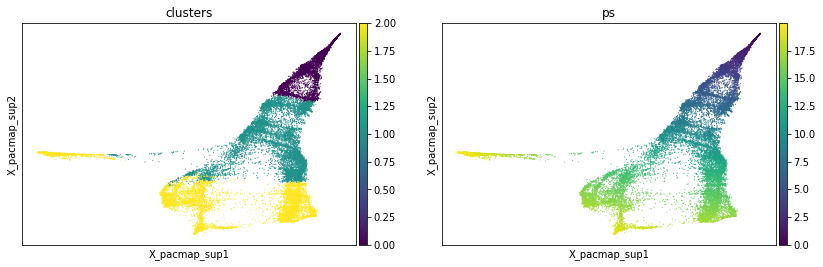

In [12]:
#define a root point
root_idx = 0
time = adata.obs['label']
bins = np.histogram(time, bins=3)[1]
adata.obs['clusters'] = np.digitize(time, bins[1:], right=True)

st2.tl.smooth_ordinal_labels(adata, root_idx, ordinal_label='clusters', obsm="X_pacmap_sup")
sc.pl.embedding(adata,'X_pacmap_sup',color=['clusters','ps'])

We then need to define 3 extra variables: root cell, ordinal labels to follow and supervision strength
- ordinal_supervision_strength = 1 means equal importance to respecting ordinal labels vs natural data order,
- ordinal_supervision_strength = 10 means ordinal labels order is 10 times more important 

Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  95  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

6||52	0.5399	52	51	38	6	0	0	0.2372	0.1969	0.993	0.9942	0.2922	0.0105	0.5463	28.4089	0
6||53	0.5101	53	52	39	6	0	0	0.2192	0.1814	0.9935	0.9947	0.2812	0.0097	0.5153	27.3126	0
5||54	0.4987	54	53	42	5	0	0	0.2145	0.1766	0.9937	0.9948	0.2735	0.0107	0.5777	31.1957	0
5||55	0.4846	55	54	43	5	0	0	0.2083	0.1728	0.9939	0.9949	0.2663	0.01	0.5492	30.2048	0
5||56	0.4768	56	55	44	5	0	0	0.2086	0.1752	0.9939	0.9948	0.2578	0.0105	0.5854	32.7803	0
4||57	0.4747	57	56	47	4	0	0	0.2199	0.1873	0.9935	0.9945	0.2465	0.0082	0.4667	26.5997	0
4||58	0.4691	58	57	48	4	0	0	0.2143	0.1813	0.9937	0.9947	0.2474	0.0075	0.4364	25.3112	0
4||59	0.4658	59	58	49	4	0	0	0.2121	0.1794	0.9938	0.9947	0.246	0.0078	0.4583	27.0391	0
4||60	0.4576	60	59	50	4	0	0	0.214	0.

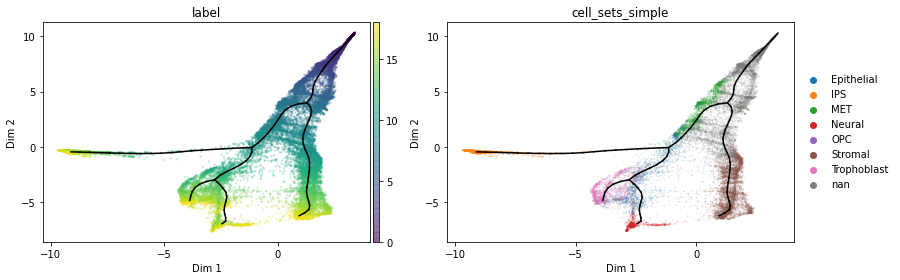

In [13]:
adata2=adata.copy()
st2.tl.learn_graph(
    adata2,
    n_nodes=90,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
    GPU=True,store_evolution=True,use_weights=True,use_seed=True,
    max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},verbose=1,
                   
    # supervision parameters
    ordinal_label = 'knn_label_vote',                            #define the ordinal vector to follow
    ordinal_root_point = root_idx,                               #define a root point (e.g., cell with lowest ordinal value)
    ordinal_supervision_strength = 1,                            #define strength of supervision in [0, +inf).
)

st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

We can also fine tune the branching points or extend branches' end points so they better cover the data

# Trajectory analysis

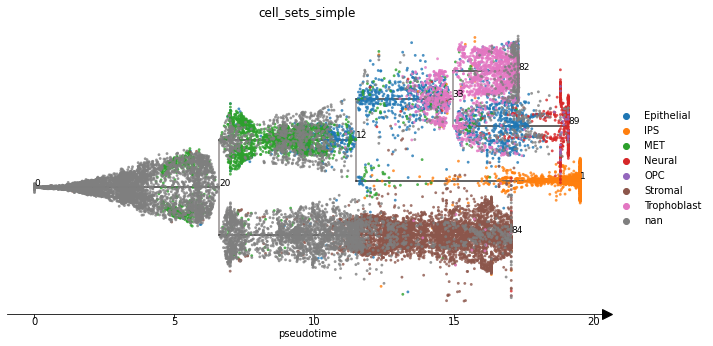

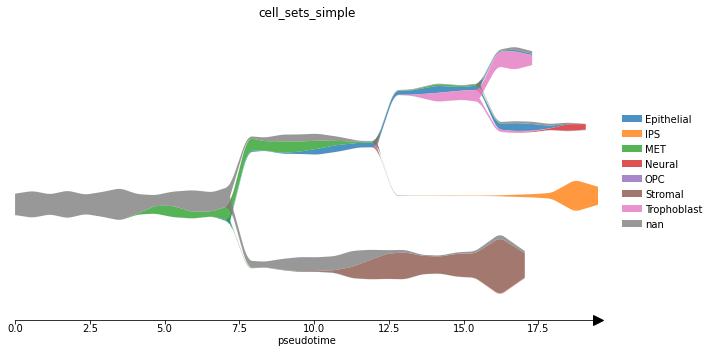

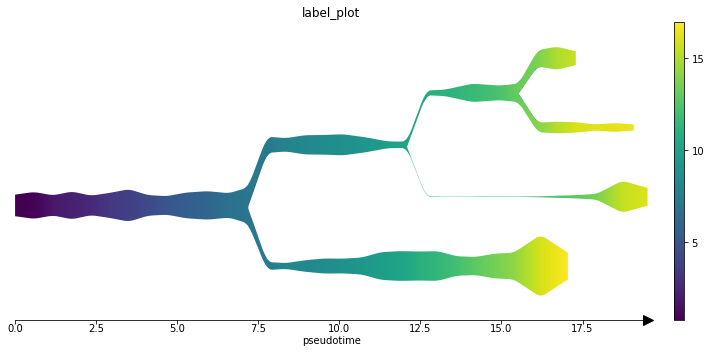

In [28]:
st2.tl.infer_pseudotime(adata2,0)
#jitter to prevent bug
adata2.obs['label_plot']=adata2.obs['label']+1e-20*np.random.random(len(adata2))

st2.pl.stream_sc(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['label_plot'],fig_size=(10,5))

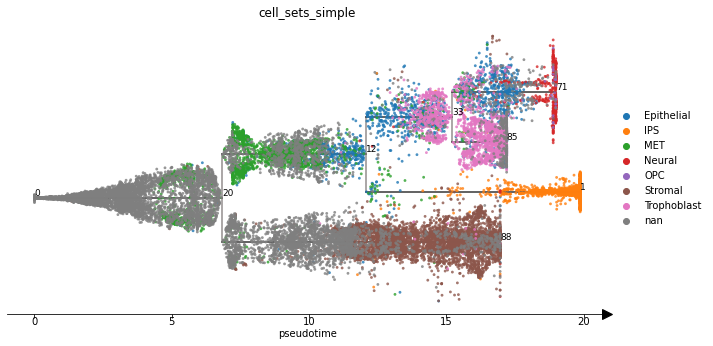

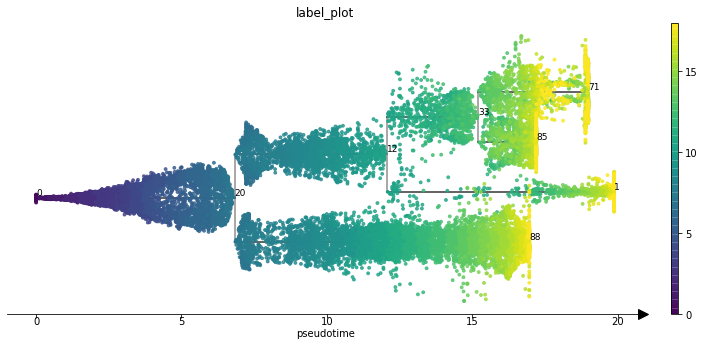

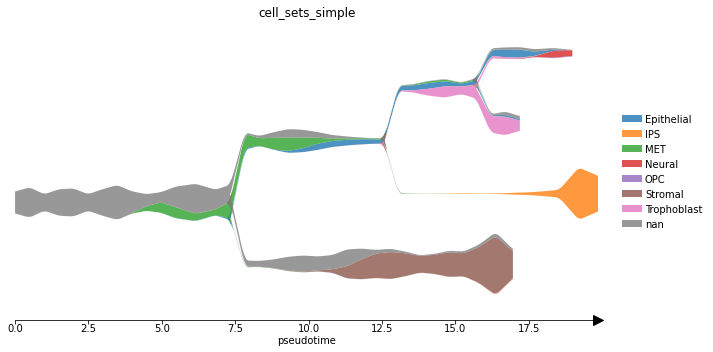

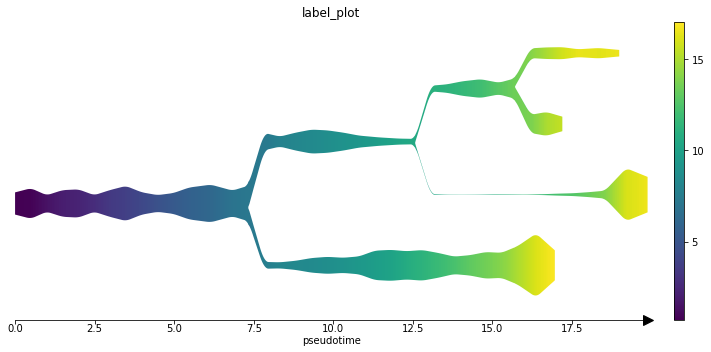

In [32]:
st2.tl.infer_pseudotime(adata2,0)
#jitter to prevent bug
adata2.obs['label_plot']=adata2.obs['label']+1e-20*np.random.random(len(adata2))

#stream_sc has to be called before stream
st2.pl.stream_sc(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream_sc(adata2,source=0,color=['label_plot'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['label_plot'],fig_size=(10,5))

In [14]:
adata2.write('../data/wot_output.h5ad')

AttributeError: 'int' object has no attribute 'encode'

Above error raised while writing key 52 of <class 'h5py._hl.group.Group'> to /

In [160]:
s_adata.uns['leaf_markers_all'].head()

,zscore,H_statistic,H_pvalue,S0S1_pvalue,S3S4_pvalue,S5S7_pvalue,S5S6_pvalue,S1S2_pvalue
Tns4,1.99996,3768.55,0,6.24036e-148,1,0,1.68367e-300,6.54968e-84
Trim29,1.99994,1755.48,0,2.07616e-67,1,0,2.26795e-137,4.54971e-38
Sycp3,1.99991,7553.03,0,0,0,0,1,0
Usp26,1.99989,3967.03,0,1.03175e-307,0,0,1,1.23273e-191
Dazl,1.99987,7360.68,0,0,0,0,1,0


In [175]:
s_adata.uns['leaf_markers'][('S3','S4')].head(10)

,zscore,H_statistic,H_pvalue,S0S1_pvalue,S3S4_pvalue,S5S7_pvalue,S5S6_pvalue,S1S2_pvalue
Tns4,1.99996,3768.55,0,6.24036e-148,1,0,1.68367e-300,6.54968e-84
Trim29,1.99994,1755.48,0,2.07616e-67,1,0,2.26795e-137,4.54971e-38
Foxq1,1.99981,1748.28,0,7.63969e-65,1,0,1.56218e-132,6.63757e-35
Cldn23,1.99975,2378.83,0,4.84528e-93,1,0,8.89121e-186,8.12373e-52
Fxyd3,1.99968,5596.6,0,8.21725e-237,1,0,0,8.7316e-136
Dnase1l3,1.99963,2859.45,0,6.10253e-110,1,0,5.94038e-231,9.01329e-66
Lypd3,1.99952,1681.68,0,1.53899e-65,1,0,1.61928e-127,1.20201e-37
Serpinb9f,1.99951,2445.39,0,1.31278e-96,1,0,5.53968e-200,2.98094e-55
Nrk,1.99939,9073.26,0,0,1,0,0,1.14965e-237
Serpinb9c,1.99936,2531.36,0,8.15101e-101,1,0,9.12883e-209,1.22836e-57


In [182]:
for k,v in s_adata.uns['leaf_markers'].items():
    print(v.head(5),'\n\n')

          zscore H_statistic H_pvalue S0S1_pvalue S3S4_pvalue S5S7_pvalue  \
Lce1g    1.99596     1874.19        0           1           0           0   
Ankrd1   1.97508     3999.29        0           1           0           0   
Lce1h    1.96863      1759.9        0           1           0           0   
Grem2    1.96835      5401.1        0           1           0           0   
Slco4a1  1.92915     4786.91        0           1           0           0   

          S5S6_pvalue   S1S2_pvalue  
Lce1g               0  1.73591e-117  
Ankrd1              0   6.4066e-251  
Lce1h    1.38126e-296   2.17271e-86  
Grem2               0  1.66887e-279  
Slco4a1             0  3.51129e-205   


         zscore H_statistic H_pvalue   S0S1_pvalue S3S4_pvalue S5S7_pvalue  \
Tns4    1.99996     3768.55        0  6.24036e-148           1           0   
Trim29  1.99994     1755.48        0   2.07616e-67           1           0   
Foxq1   1.99981     1748.28        0   7.63969e-65           1          

In [175]:
s_adata.uns['leaf_markers'][('S3','S4')].head(10)

,zscore,H_statistic,H_pvalue,S0S1_pvalue,S3S4_pvalue,S5S7_pvalue,S5S6_pvalue,S1S2_pvalue
Tns4,1.99996,3768.55,0,6.24036e-148,1,0,1.68367e-300,6.54968e-84
Trim29,1.99994,1755.48,0,2.07616e-67,1,0,2.26795e-137,4.54971e-38
Foxq1,1.99981,1748.28,0,7.63969e-65,1,0,1.56218e-132,6.63757e-35
Cldn23,1.99975,2378.83,0,4.84528e-93,1,0,8.89121e-186,8.12373e-52
Fxyd3,1.99968,5596.6,0,8.21725e-237,1,0,0,8.7316e-136
Dnase1l3,1.99963,2859.45,0,6.10253e-110,1,0,5.94038e-231,9.01329e-66
Lypd3,1.99952,1681.68,0,1.53899e-65,1,0,1.61928e-127,1.20201e-37
Serpinb9f,1.99951,2445.39,0,1.31278e-96,1,0,5.53968e-200,2.98094e-55
Nrk,1.99939,9073.26,0,0,1,0,0,1.14965e-237
Serpinb9c,1.99936,2531.36,0,8.15101e-101,1,0,9.12883e-209,1.22836e-57
